In [1]:
from libraries import lib
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy.random as npr
import random

class SparseStateVector:
    """
    Container class for dictionary (self.values) with keys of integer states
    and values being complex amplitude of psi
    """
    def __init__(self):
        self.values = {}
        self.normalized = False

    def TFIM_multiply(psi, N, J, Gamma):
        """
        Returns new sparse vector representing H|psi>
        """
        prod = SparseStateVector()
        for state in psi.values:
            jtotal = 0
            for site in range(N - 1):
                jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
            jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
            prod.values[state] = jtotal * psi.values[state]
        
        for state in psi.values:
            for site in range(N):
                flipped_state = state ^ (1 << site)
                prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
        return prod

    def inner_product(v1, v2):
        """
        Returns <v1|v2> for two SparseStateVectors
        """
        prod = 0
        for s in v1.values:
            if s in v2.values:
                prod += torch.conj(v1.values[s]) * v2.values[s]
        return prod

    def TFIM_expectation_from_sparse(psi, N, J, Gamma):
        """
        Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
        """
        # do H|psi> then <psi| (H|psi>)
        hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
        exp = SparseStateVector.inner_product(psi, hpsi)
        if not psi.normalized:
            mag2 = SparseStateVector.inner_product(psi, psi)
            return (exp / mag2).real
        return exp.real

    def normalize(self):
        """
        Normalizes values
        """
        mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
        for s in self.values:
            self.values[s] = self.values[s] / mag
        self.normalized = True

    def to_prob_distribution(self, N):
        """
        Returns 1D list representing real probability distribution
        """
        if not self.normalized:
            mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
            return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
        return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
    def to_dense_vector(self, N):
        """
        Returns 1D list of dense representation
        """
        if not self.normalized:
            mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
            return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
        return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

class UniformNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, num_samples, informed = False):
        """
        Initializes sparse vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            num_samples (int): number of unique integer samples to take
            informed (bool): whether to guarantee sample first and last states
        """
        super().__init__()
        self.samples = num_samples
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        if num_samples >= 2 ** N:
            for state in range(2 ** N):
                self.distribution[state] = 1
                self.list.append(state)
                self.values[state], self.nn_output[state] = psi(state)
        else:
            sampled_states = set()
            if informed: 
                sampled_states.add(0)
                self.distribution[0] = self.distribution.get(0, 0) + 1
                self.list.append(0)
                sampled_states.add(2 ** N - 1)
                self.distribution[2 ** N - 1] = self.distribution.get(2 ** N - 1, 0) + 1
                self.list.append(2 ** N - 1)
                num_samples = num_samples - 2
            for _ in range(num_samples):
                x = random.getrandbits(N)
                while x in sampled_states:
                    x = random.getrandbits(N)
                sampled_states.add(x)
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            for state in sampled_states:
                self.values[state], self.nn_output[state] = psi(state)

class MHNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0, informed = False):
        """
        Initializes distribution of samples and vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            x_func (function): takes in state x and generates proposal x*
            x0 (int): intger state to begin sampling
            num_samples (int): number of proposal x* generated
            burnin (int): number of samples to throw away before accepting first sample
            lag (int): number of samples to throw away in-between accepting samples
            informed (bool): whether to guarantee sample first and last states
        """
        # uses arbitrary x_func for MH sampling
        super().__init__()
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        self.samples = num_samples
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        num_uniform = burnin + num_samples * (lag + 1)
        rand_uniform = npr.uniform(0, 1, num_uniform)
        index = 0
        if informed: 
            self.values[0], self.nn_output[0] = psi(0)
            self.values[2 ** N - 1], self.nn_output = psi(2 ** N - 1)
            self.distribution[0] = 1
            self.list.append(0)
            self.distribution[2 ** N - 1] = 1
            self.list.append(2 ** N - 1)
            num_samples = num_samples - 2
        x = x0
        psi_val, nn_val = psi(x)
        self.values[x] = psi_val
        self.nn_output[x] = nn_val
        for _ in range(burnin):
            new_x = x_func(x)
            new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                x = new_x
                psi_val = new_psi_val
            index += 1
        for _ in range(num_samples):
            for _ in range(lag):
                new_x = x_func(x)
                new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
                ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
                if ratio > 1 or ratio > rand_uniform[index]:
                    x = new_x
                    psi_val = new_psi_val
                index += 1
            new_x = x_func(x)
            if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
            else: new_psi_val, new_nn_val = psi(new_x)
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
                self.list.append(new_x)
                x = new_x 
                psi_val = new_psi_val 
            else: 
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            self.values[new_x] = new_psi_val
            self.nn_output[new_x] = new_nn_val
            index += 1

    # def distribution_to_list(self):
    #     """
    #     Returns list of sampled states with repetition
    #     """
    #     return [state for state in self.distribution for _ in range(self.distribution[state])]

In [3]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * 2 * np.pi * nn_output[:, 1])
c = 1e-8
def log_amp_phase_c(nn_output):
    return (torch.exp(nn_output[:, 0]) - c) * torch.exp(1.j * 2 * np.pi * nn_output[:, 1]) 
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
N = 4; J = 1; Gamma = 1

In [5]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
)

In [6]:
model(torch.tensor([lib.generate_state_array(0, N)], dtype = torch.float32))

tensor([[-0.1843, -0.5169]], grad_fn=<AddmmBackward0>)

In [7]:
log_amp_phase_c(model(torch.tensor([lib.generate_state_array(0, N)], dtype = torch.float32)))[0]

tensor(-0.8271+0.0879j, grad_fn=<SelectBackward0>)

In [8]:
num_samples = 200
mhn = MHNeuralState(N, model, log_amp_phase_c, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)

In [9]:
len(mhn.values)

16

In [10]:
mhn.list

[0,
 2,
 2,
 10,
 8,
 10,
 8,
 10,
 8,
 12,
 8,
 0,
 2,
 0,
 1,
 3,
 7,
 6,
 4,
 0,
 1,
 9,
 11,
 15,
 14,
 12,
 13,
 9,
 11,
 3,
 2,
 10,
 14,
 15,
 11,
 10,
 11,
 15,
 7,
 5,
 4,
 6,
 2,
 3,
 2,
 6,
 14,
 12,
 8,
 10,
 14,
 15,
 14,
 15,
 7,
 6,
 14,
 15,
 11,
 3,
 3,
 1,
 3,
 11,
 9,
 13,
 12,
 13,
 5,
 13,
 9,
 8,
 0,
 1,
 9,
 11,
 9,
 13,
 15,
 13,
 9,
 11,
 3,
 11,
 9,
 13,
 9,
 11,
 10,
 2,
 3,
 11,
 15,
 11,
 3,
 11,
 11,
 10,
 11,
 3,
 1,
 5,
 7,
 5,
 7,
 6,
 14,
 12,
 4,
 6,
 4,
 12,
 8,
 12,
 8,
 12,
 13,
 9,
 11,
 9,
 1,
 0,
 1,
 9,
 8,
 12,
 8,
 9,
 11,
 3,
 7,
 7,
 6,
 4,
 6,
 4,
 12,
 13,
 9,
 13,
 12,
 13,
 12,
 4,
 5,
 13,
 5,
 4,
 0,
 2,
 6,
 4,
 12,
 4,
 6,
 7,
 3,
 11,
 9,
 8,
 12,
 8,
 0,
 1,
 5,
 1,
 9,
 1,
 5,
 4,
 6,
 7,
 3,
 7,
 3,
 7,
 5,
 7,
 6,
 2,
 3,
 1,
 3,
 7,
 5,
 1,
 9,
 1,
 0,
 2,
 6,
 4,
 6,
 2,
 0,
 4,
 6,
 7,
 5,
 7]

In [11]:
np.log(1.j)

np.complex128(1.5707963267948966j)

In [12]:
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    res = 0
    total_amp = 0
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * (torch.exp(output_prime[0]) - c) / (torch.exp(output[0]) - c) * torch.exp(1.j * 2 * np.pi * (output_prime[1] - output[1]))
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        # state_amp = abs(sampled_vector.values[basis_state]) ** 2
        # total_amp += state_amp
        # res += state_amp * eloc
        eloc_values.append(eloc)
        # for _ in range(sampled_vector.distribution[basis_state]):
        #     eloc_values.append(eloc)
    return eloc_values
    # return (res / total_amp).real

In [13]:
ustate = UniformNeuralState(N, model, log_amp_phase, 2 ** N)
print(SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma).item())
print(torch.tensor(generate_eloc_list(ustate, N, J, Gamma, model)).mean().item())
print(lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, log_amp_phase).item())

-3.9348270893096924
(-3.934326648712158+0.012485835701227188j)
-3.9348270893096924


In [14]:
sum(generate_eloc_list(ustate, 4, J, Gamma, model)).conj()

tensor(-62.9492-0.1998j, grad_fn=<ConjBackward0>)

In [15]:
mhstate = MHNeuralState(N, model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), 10000)
print(torch.tensor(generate_eloc_list(mhstate, N, J, Gamma, model)).mean().item())
print(lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, log_amp_phase).item())

(-3.945019483566284-0.004695235285907984j)
-3.9348270893096924


In [16]:
N = 20; J = 1; Gamma = 10

In [17]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [18]:
torch.tensor([1, 2, 3]) * torch.tensor([2, 3, 4])

tensor([ 2,  6, 12])

In [19]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
) # logsig logsig is good, relu bad
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.Sigmoid(),
#     nn.Linear(5 * N, 2),
#     nn.Sigmoid()
# ) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    # log_psi_conj = [torch.log(model(torch.tensor(lib.generate_state_array(x, N), dtype=torch.float32))).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    # loss = generate_eloc_list(MHNeuralState(N, model, log_amp_phase,
    #                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples),
    #                                           N, J, Gamma, model)
    # loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, log_amp_phase, 
    #                                                        lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
    #                                                        N, J, Gamma, model, log_amp_phase) # this works Gamma = 10
    # print(loss, energy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-199.4475-1.4821j) 1.5543893575668335
1 tensor(-192.5705+0.8202j) 6.825778484344482
2 tensor(-201.4198+1.4494e-21j) 0.0007281620637513697
3 tensor(-201.2586+1.2746e-23j) 0.0009011440561152995
4 tensor(-200.6278+2.5776e-17j) 0.0028241772670298815
5 tensor(-200.2874+1.4612e-20j) 0.0011033681221306324
6 tensor(-199.9870+5.3033e-17j) 0.0009404314332641661
7 tensor(-199.2704+4.8522e-23j) 0.0002260108303744346
8 tensor(-199.4720+1.5260e-22j) 0.000267515832092613
9 tensor(-200.4566+3.2954e-22j) 0.0006200806237757206
10 tensor(-200.2726+6.3689e-20j) 0.0008147378102876246
11 tensor(-199.7597+1.1802e-23j) 0.0002353754243813455
12 tensor(-199.7680+3.3512e-22j) 0.0003516240103635937
13 tensor(-200.2309+6.7200e-25j) 3.832943184534088e-05
14 tensor(-199.8478+1.5177e-22j) 0.00021572808327618986
15 tensor(-199.3695+2.9446e-17j) 0.0034827825147658587
16 tensor(-200.5483+2.5449e-17j) 0.0011551324278116226
17 tensor(-200.4479-4.9007e-16j) 0.005845549050718546
18 tensor(-200.9981+2.4851e-17j) 0.0

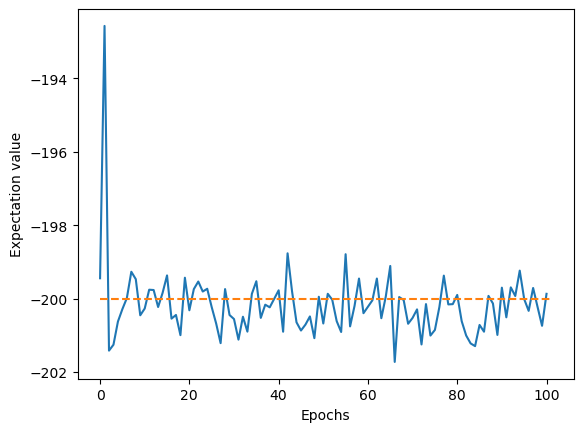

In [20]:
# ground state energy about -10N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-10 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [21]:
Gamma = 0.1

In [22]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [23]:
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.SiLU(),
#     nn.Linear(5 * N, 2),
#     nn.SiLU(),
# )
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.LogSigmoid(),
    nn.Linear(5 * N, 2),
    nn.LogSigmoid()
) # relu bad, silu ??, logsig good, stuff often gets stuck at 16?
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-2.5081+0.0073j) -0.12113217264413834
1 tensor(-2.6425-0.0078j) 0.027340149506926537
2 tensor(-1.5328-0.0128j) 0.00267044804058969
3 tensor(-2.7814-7.3509e-05j) 0.02201199159026146
4 tensor(-1.9099-0.0030j) 0.006112594623118639
5 tensor(-1.4872-0.0030j) -0.0030299618374556303
6 tensor(-3.2463-0.0007j) -9.698417852632701e-05
7 tensor(-2.6544+0.0011j) 0.003565383842214942
8 tensor(-1.2788+0.0010j) 0.01086414698511362
9 tensor(-2.6236-0.0008j) 0.004932904615998268
10 tensor(-2.0309+0.0005j) 0.0016833669506013393
11 tensor(-2.9275-0.0054j) 0.002575119026005268
12 tensor(-1.0238-0.0034j) 0.0002318028564332053
13 tensor(-2.0954+0.0024j) -0.0022315618116408587
14 tensor(-1.5039-0.0045j) -0.007327516563236713
15 tensor(-1.8878-2.3511e-05j) 0.0019059996120631695
16 tensor(-1.4475-8.6085e-05j) -0.004505596589297056
17 tensor(-2.4957-0.0010j) 0.006754061672836542
18 tensor(-1.4715-0.0011j) 0.004654597956687212
19 tensor(-1.5198-0.0027j) -0.005708795972168446
20 tensor(-1.4315+0.0022j) 0.

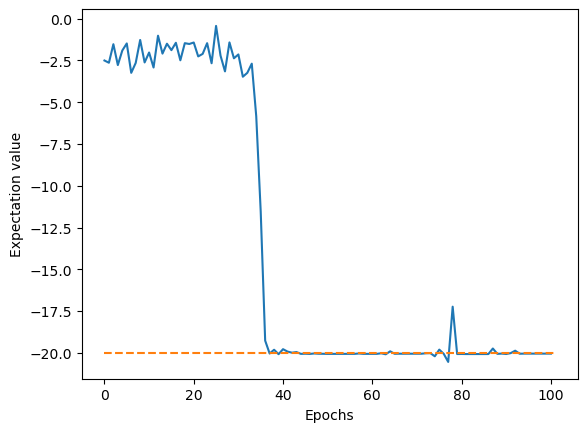

In [24]:
# ground state energy about -N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [25]:
Gamma = 1

In [26]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [27]:
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.LogSigmoid(),
#     nn.Linear(5 * N, 2),
#     nn.LogSigmoid(),
# )
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
)
# silu got to -23 1st run, second run -25 and logsig only -20 at 250 samples
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-20.6920-0.0541j) 0.03409389406442642
1 tensor(-19.2154+0.0310j) 0.17727987468242645
2 tensor(-20.7994+0.0888j) -0.08180359750986099
3 tensor(-19.9439-0.0203j) -0.04946564510464668
4 tensor(-20.3395+0.0539j) -0.018879657611250877
5 tensor(-19.8400+0.0171j) -0.07316742837429047
6 tensor(-20.8349+0.0139j) -0.1580900400876999
7 tensor(-20.2497+0.0155j) 0.07158351689577103
8 tensor(-20.0622+0.0313j) 0.5582048296928406
9 tensor(-19.2384+0.0030j) -0.05573849380016327
10 tensor(-20.7396+0.0059j) -0.1452425867319107
11 tensor(-18.9568+0.0106j) -0.5399079918861389
12 tensor(-20.7242-0.0029j) 0.2771373391151428
13 tensor(-19.3266-0.0045j) 0.7148677110671997
14 tensor(-20.0985-0.0044j) 0.38670822978019714
15 tensor(-20.1269-0.0072j) 0.5291229486465454
16 tensor(-20.1002-0.0027j) 0.01857011206448078
17 tensor(-20.1396+0.0091j) -0.1332302987575531
18 tensor(-20.8178+0.0204j) -1.0395708084106445
19 tensor(-21.2535+0.0079j) -0.2943829894065857
20 tensor(-21.3097-0.0117j) 0.9729654788970947
2

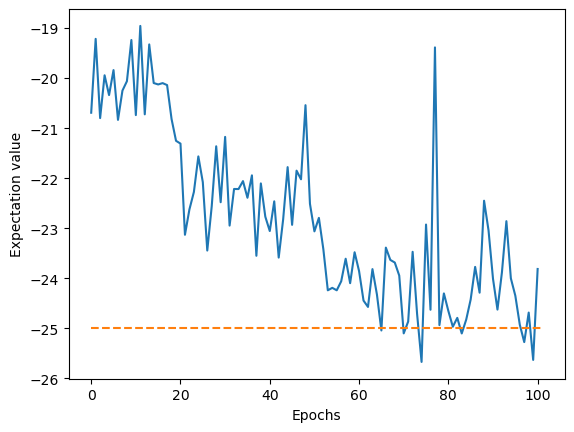

In [28]:
# ground state energy about -1.25 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-1.25 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [29]:
# def logcosh(x, clip_max=1e20): # have to clip this to avoid infinity, somehow infinity divide 2 results in a nan in jax
#     sgn_x = -2 * jnp.signbit(x.real) + 1
#     x = x * sgn_x
#     return jnp.clip(x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0), -clip_max, clip_max)
class LogCosh(nn.Module):
    def __init__(self):
        super(LogCosh, self).__init__()
    def forward(self, x, clip_max = 1e20):
        sgn_x = -2 * torch.signbit(x.real) + 1
        temp = x * sgn_x
        return torch.clamp(temp + torch.log1p(torch.exp(-2.0 * temp)) - np.log(2.0), min=-clip_max, max=clip_max)

In [30]:
Gamma = 10
num_samples = 150

In [31]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
    nn.SiLU()
)
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-198.3134-0.9216j) 1.0784809589385986
1 tensor(-152.8105-5.0590j) 16.288169860839844
2 tensor(-198.6933+0.j) 0.0
3 tensor(-202.0800+0.j) 0.0
4 tensor(-200.1867+0.j) 0.0
5 tensor(-201.4667+0.j) 0.0
6 tensor(-201.1200+0.j) 0.0
7 tensor(-199.5733+0.j) 0.0
8 tensor(-199.7333+0.j) 0.0
9 tensor(-201.6000+0.j) 0.0
10 tensor(-200.9333+0.j) 0.0
11 tensor(-200.7733+0.j) 0.0
12 tensor(-201.9200+0.j) 0.0
13 tensor(-199.6000+0.j) 0.0
14 tensor(-201.6000+0.j) 0.0
15 tensor(-201.3067+0.j) 0.0
16 tensor(-199.9733+0.j) 0.0
17 tensor(-201.3867+0.j) 0.0
18 tensor(-199.0933+0.j) 0.0
19 tensor(-198.2400+0.j) 0.0
20 tensor(-201.0667+0.j) 0.0
21 tensor(-200.0267+0.j) 0.0
22 tensor(-198.6133+0.j) 0.0
23 tensor(-200.8800+0.j) 0.0
24 tensor(-201.9467+0.j) 0.0
25 tensor(-199.3867+0.j) 0.0
26 tensor(-197.6800+0.j) 0.0
27 tensor(-199.7600+0.j) 0.0
28 tensor(-200.8533+0.j) 0.0
29 tensor(-200.1333+0.j) 0.0
30 tensor(-202.1600+0.j) 0.0
31 tensor(-200.3200+0.j) 0.0
32 tensor(-199.8667+0.j) 0.0
33 tensor(-199.

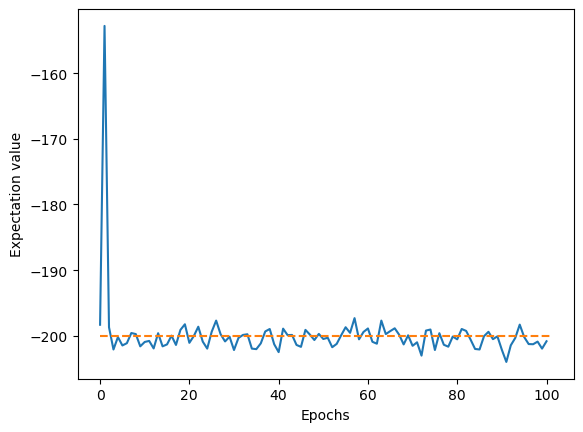

In [32]:
# ground state energy about -10 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-10 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [33]:
Gamma = 0.1
num_samples = 150

In [34]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-2.5404-0.0345j) 0.00805275235325098
1 tensor(-3.2485-0.0334j) -0.15984970331192017
2 tensor(-1.3159+0.0400j) 0.04967037960886955
3 tensor(-1.8565+0.0308j) -1.6089959144592285
4 tensor(-11.8779-0.0054j) -2.563406467437744
5 tensor(-17.7126-0.4242j) -4.70005464553833
6 tensor(6.5700e+09-1.0172e+10j) -115459710976.0
7 tensor(nan+nanj) nan
8 tensor(nan+nanj) nan
9 tensor(nan+nanj) nan
10 tensor(nan+nanj) nan
11 tensor(nan+nanj) nan
12 tensor(nan+nanj) nan
13 tensor(nan+nanj) nan
14 tensor(nan+nanj) nan
15 tensor(nan+nanj) nan
16 tensor(nan+nanj) nan
17 tensor(nan+nanj) nan
18 tensor(nan+nanj) nan
19 tensor(nan+nanj) nan
20 tensor(nan+nanj) nan
21 tensor(nan+nanj) nan
22 tensor(nan+nanj) nan
23 tensor(nan+nanj) nan
24 tensor(nan+nanj) nan
25 tensor(nan+nanj) nan
26 tensor(nan+nanj) nan
27 tensor(nan+nanj) nan
28 tensor(nan+nanj) nan
29 tensor(nan+nanj) nan
30 tensor(nan+nanj) nan
31 tensor(nan+nanj) nan
32 tensor(nan+nanj) nan
33 tensor(nan+nanj) nan
34 tensor(nan+nanj) nan
35 ten

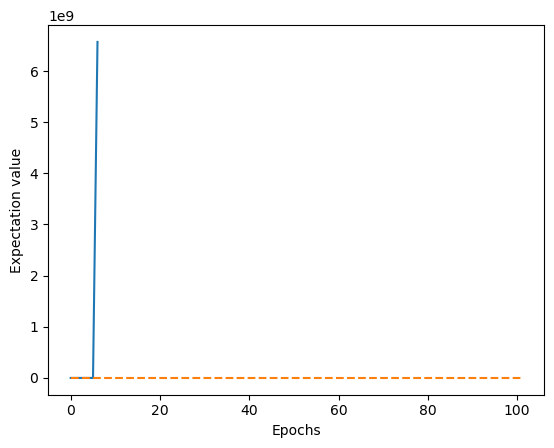

In [35]:
# ground state energy about -N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [36]:
Gamma = 1
num_samples = 500

In [37]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
    nn.SiLU()
)
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-19.6728+0.0843j) 0.11211346089839935
1 tensor(-21.1723+0.0746j) 0.07045690715312958
2 tensor(-21.0502+0.0024j) 0.020709024742245674
3 tensor(-20.2042+0.0074j) 0.0426793247461319
4 tensor(-20.6946-0.0122j) 0.01774226687848568
5 tensor(-20.0060-0.0014j) -0.00917750783264637
6 tensor(-20.2191-0.0070j) 0.01608620211482048
7 tensor(-19.5637+0.0378j) -0.029721206054091454
8 tensor(-20.7836-0.0217j) 0.01445336639881134
9 tensor(-20.3007-0.0149j) -0.050984155386686325
10 tensor(-19.6741-0.0044j) -0.06670262664556503
11 tensor(-20.9632+0.0348j) -0.062358126044273376
12 tensor(-21.0052-0.0021j) -0.08812718838453293
13 tensor(-21.4866+0.0139j) -0.06946329772472382
14 tensor(-20.6957-0.0190j) -0.17339028418064117
15 tensor(-21.0848-0.0261j) -0.194590225815773
16 tensor(-20.1628-0.0239j) -0.40188145637512207
17 tensor(-20.1614+0.0042j) -0.6249533891677856
18 tensor(-23.3730+0.0205j) 0.9174771308898926
19 tensor(-20.9509-0.0187j) -0.34371259808540344
20 tensor(-22.2502-0.0312j) 1.244727015

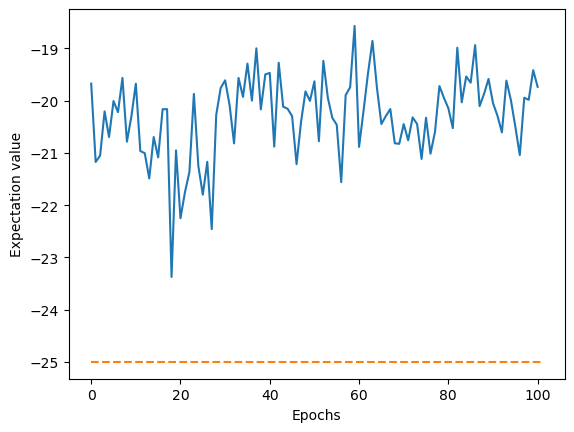

In [38]:
# ground state energy about -1.25 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-1.25 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()